<!--
Universidad Internacional de Valencia<br/>
Máster Universitario en Inteligencia Artificial<br/>
07MIAR: Redes Neuronales y Deep Learning<br/>
Daniel Felipe Hernández Mancipe<br/>

---
-->

#### Nota importante

Me excedí en el número de páginas debido a la longitud de la salida de `resunet.summary()`, y a su explicación, que no se solicitó explícitamente en el enunciado, pero que tampoco quedó claro si solamente se debía mostrar el resultado de `resunet.summary()`, que quedaba muy simple en mi opinión, entonces por prevenir añadí una explicación. Adicionalmente, en el tercer punto, tuve utilizar, entre otras, una rejilla de imágenes de 8x3, para poder desarrollar el análisis de manera adecuada, lo que también consumió bastante espacio de páginas.

---

* Artículo científico: [Zhang, Z., Liu, Q., & Wang, Y. (2017). *Road Extraction by Deep Residual U-Net*](https://arxiv.org/pdf/1711.10684)
* Repositorio de la implementación pre-entrenada: [github.com/edwinpalegre/EE8204-ResUNet](https://github.com/edwinpalegre/EE8204-ResUNet)

### 1. Model summary

In [4]:
from tensorflow import keras
from skimage.io import imread
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
# compile=False since it is only for inference
# safe_mode=False to enable unsafe deserialization
resunet = keras.models.load_model("BestResUNet.hdf5", compile=False, safe_mode=False)
resunet.name = "Deep_Residual_UNet"
resunet.summary()

ValueError: bad marshal data (unknown type code)

La salida de `resunet.summary()` muestra la estructura capa por capa de la [Deep Residual U-Net pre-entrenada](https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/Best%20ResUNet.hdf5), incluyendo el nombre de cada capa, el tipo, la forma de salida, el número de parámetros y las conexiones de salto.

#### Estructura general

El modelo es una red encoder-decoder en forma de U construida con bloques residuales.
* El encoder (ruta izquierda en la figura 2 del artículo) reduce progresivamente la resolución de la imagen para capturar el contexto.
* El decoder (ruta derecha en la figura 2 del artículo) vuelve a muestrear a la resolución completa para producir una máscara de segmentación por píxeles.
* Omite las conexiones entre las capas del encoder y el decoder a la misma escala para conservar los detalles espaciales.

#### Encoder (ruta de submuestreo)

* Capas como `conv2d`, `batch_normalization` y `activation` aparecen repetidamente.
* Cada bloque reduce a la mitad la resolución espacial y aumenta la profundidad de las características (por ejemplo, 64 → 128 → 256 → 512).
* Las conexiones residuales (capas `Add`) combinan la entrada y la salida de cada bloque, estabilizando el entrenamiento y permitiendo redes más profundas.

#### Bottleneck (Bridge)

* Las capas más profundas (por ejemplo, `conv2d_11`–`conv2d_13`) capturan características semánticas de alto nivel de las carreteras con baja resolución (por ejemplo, (14, 14, 512)).

#### Decoder (ruta de sobremuestreo)

* Utiliza capas `UpSampling2D` y `Concatenate` para fusionar características del codificador de etapas anteriores.
* Cada paso duplica la resolución y reduce el número de filtros.
* Estas conexiones omitidas ayudan a recuperar detalles finos (como los límites estrechos de las carreteras).

#### Cabezal de salida

* Capa final: `Conv2D (1×1)` → forma de salida (224, 224, 1).
* Activación: `Sigmoide`, que proporciona un mapa de probabilidades en el que cada valor de píxel $\in [0, 1]$ indica la probabilidad de que se trate de una carretera.

#### Parámetros

* Total de parámetros entrenables $\approx 8–9$ millones, dependiendo de la configuración exacta.
* La mayoría de los parámetros residen en las capas convolucionales más profundas (el cuello de botella y el decoder).

### 2. Ejemplo concreto (imagen) y explicación del tensor de entrada

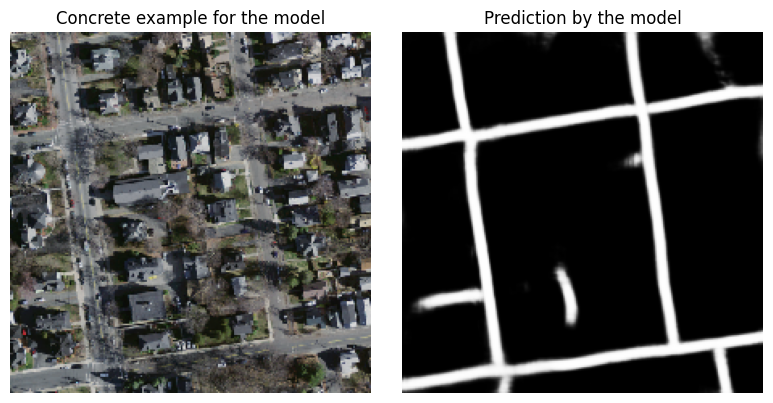

In [62]:
# load the image
x = np.zeros((1, 224, 224, 3), dtype=np.uint8)
x[0] = imread("input.png")

# pass the image to the model
y = resunet.predict(x, verbose=False)
y = np.squeeze(y*255)
y = Image.fromarray(y)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(x[0])
axs[0].set_title("Concrete example for the model")
axs[0].axis("off")
axs[1].imshow(y)
axs[1].set_title("Prediction by the model")
axs[1].axis("off")

# Plot
plt.tight_layout()
plt.show()

### Forma del tensor de entrada

El modelo espera una entrada con la siguiente forma:

$$
(224, 224, 3)
$$

* 224 × 224: Dimensiones espaciales (altura y anchura) de cada fragmento de imagen.
* 3 canales: Canales de imagen en color RGB.
* Cuando se pasa al modelo durante el entrenamiento o la inferencia, se convierte en un tensor 4D:
$$
(batch\_size, 224, 224, 3)
$$
Por ejemplo, `(1, 224, 224, 3)` para predecir una sola imagen.

### Rango de valores esperados

* Las imágenes se leen como matrices RGB (0-255) de 8 bits.
* En la segunda capa de la red se define una [función lambda](https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py#L101) que los convierte a `float32` al normalizarlos al rango:
$$
[0.0, 1.0]
$$

dividiendo cada píxel por 255.

Esta normalización es fundamental porque:
* Garantiza una magnitud constante para los filtros convolucionales y las conexiones residuales.
* Acelera la convergencia y estabiliza el entrenamiento al mantener las activaciones dentro de un rango numérico razonable.

Es importante notar que el modelo no está centrado en la media ni estandarizado (sin resta de la media de ImageNet), solo escala las intensidades de píxeles sin procesar a [0, 1].

## 3. Encoder

El modelo ResUNet implementado tiene un encoding path compuesto por [un bloque convolucional](https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py#L58) y [dos bloques residuales](https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py#L62). La última capa del encoder es `add_2`, por lo que para poder generar la salida del encoder solamente, es necesario cargar el modelo hasta dicha capa sin cargar la capa sigmoide, luego se deben cargar los pesos por el nombre de la capa, ya que dado que el modelo truncado no contiene la capa sigmoide, esos pesos nunca se cargan. Por otro lado, cada bloque del encoder reduce a la mitad la resolución espacial y aumenta la profundidad de las características. Su última capa, `add_2`, genera mapas de características con una forma (56, 56, 256). Dado que se trata de tensores de características de alta dimensión (256 canales), no es posible visualizarlos directamente como una imagen. Lo que si se puede hacer, es visualizar algunos canales de características individuales como mapas de calor para ver qué patrones espaciales han aprendido (bordes, texturas, etc.).

In [1]:
# last-downsample layer
last_encoder_layer = resunet.get_layer("add_2").output
# build encoder
encoder = tf.keras.Model(inputs=resunet.inputs, outputs=last_encoder_layer, name="Encoder")
encoder.load_weights(
    "pretrained_model.hdf5", 
    by_name=True, # match by layer name
    skip_mismatch=True # ignore layers not in this model (e.g., sigmoid layer)
)

# pass the previous image to the encoder
features = encoder.predict(x, verbose=False)
# some channel indices to visualize 
channels_to_show = [0, 1, 2, 50, 100, 150, 200, 250]
# visualize
fig, axs = plt.subplots(8, 3, figsize=(12, 32))
for i, ch in enumerate(channels_to_show):
    upsampled = tf.image.resize(features[0][..., None, ch], (224, 224)).numpy().squeeze()
    axs[i, 0].imshow(features[0][..., ch])
    axs[i, 0].set_title(f"Channel {ch}")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(x[0])
    axs[i, 1].imshow(upsampled, alpha=0.5)
    axs[i, 1].set_title(f"Channel {ch} attetion overlay")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(x[0])
    axs[i, 2].set_title("Original image")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'resunet' is not defined

Cada subplot de la primera columna muestra un mapa de características (en forma de mapa de calor) del encoder, donde las áreas más brillantes significan una activación más fuerte para ese canal. Sin embargo, dada la baja resolución de las imágenes a ese punto del encoder, solo con esa columna no es tan sencillo identificar a simple vista cual es el patrón espacial que ha aprendido cada canal. Solo con el mapa de calor, el único al que se podría más o menos correlacionar de manera directa con algún patrón espacial de la imagen original es el canal 1, que pareciera estár más activo en las zonas donde hay techos de casas, por lo que se podría presuponer que ese canal aprendió las texturas que tienen los techos de las casas. Con el objetivo de subsanar lo anterior, se realizó un overlay de la atención de cada canal sobre la imagen original, con esto, se observa que los canales 0, 1 y 2 tienen activación alta en los bordes de las cuadras y en los árboles, estando el 2 más enfocado en los árboles. El canal 50 parece estar muy enfocado en los bordes y esquinas de las cuadras; el 100 y el 150 en los techos de las casas; el 200 parece combinar los anterioes, teniendo alta activación en los bordes, los árboles y los techos; finalmente, el 255 parece estar enfocado en las esquinas, y objetos puntuales en los bordes que no se alcazan a percibir completamente debido a la baja resolución de las imágenes.

A continuación se procede a visualizar la activación agregada, en un intento de obtener una idea más general de dónde se *enfoca* especialmente el encoder, para lo cual se toma la media de todos los canales. Esto proporciona un mapa de calor de activación en 2D, donde como es de esperarse, las zona brillantes marcan las regiones que el encoder ha considerado más informativas (por ejemplo, carreteras, bordes, etc.).

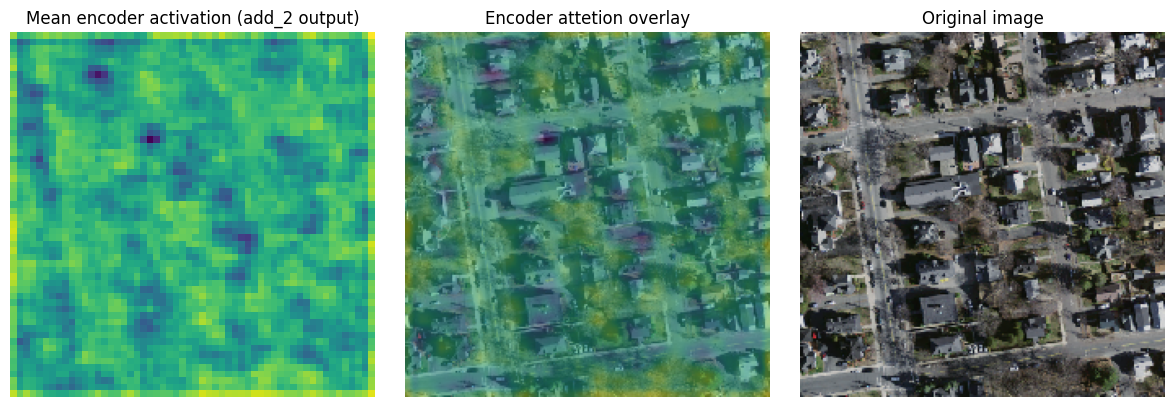

In [61]:
mean_activation = features.mean(axis=-1) # shape (56, 56)
upsampled = tf.image.resize(mean_activation[0][..., None], (224, 224)).numpy().squeeze()

# visualize
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(mean_activation[0])
axs[0].set_title("Mean encoder activation (add_2 output)")
axs[0].axis("off")
axs[1].imshow(x[0])
axs[1].imshow(upsampled, alpha=0.5)
axs[1].set_title("Encoder attetion overlay")
axs[1].axis("off")
axs[2].imshow(x[0])
axs[2].set_title("Original image")
axs[2].axis("off")

# Plot
plt.tight_layout()
plt.show()

Desafortunadamente, la activación agregada por si sola tampoco brindó una idea muy clara, se puede ver que el mapa de calor tiene activación en las zonas donde hay carreteras, pero también está relativamente activo en otras donde no hay carreteras, como en los bordes de las mismas con las casas y los jardínes, aunque con ligeramente menor activación. Para subsanar lo anterior e intentar tener una idea más clara, se realizó también una superposición de la activación agregada sobre la imagen original, lo cual fué bastante útil, ya que parece indicar que el encoder se activa más en los bordes de las carreteras, las esquinas de las cuadras, y los árboles de la zona. 